In [2]:
import glob
import logging
import os
from pathlib import Path
import random
import shutil
import sys
import tempfile
import time
import warnings
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import pydicom
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm

import ignite
from ignite.engine import create_supervised_trainer, create_supervised_evaluator

from monai.config import print_config
from monai.data import (
    ArrayDataset,
    create_test_image_3d,
    decollate_batch,
    DataLoader,
    Dataset,
    PydicomReader,
    pad_list_data_collate,
)
from monai.handlers import (
    MeanDice,
    MLFlowHandler,
    StatsHandler,
    TensorBoardImageHandler,
    TensorBoardStatsHandler,
)
from monai.losses import DiceLoss
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    EnsureType,
    AsDiscrete,
    Compose,
    LoadImage,
    RandSpatialCrop,
    Resize,
    ScaleIntensity,
    Lambda,
    # dict-based variants
    LoadImaged,
    ScaleIntensityd,
    EnsureChannelFirstd,
    Resized,
    EnsureTyped,
    Lambdad,
    RandSpatialCropd,
    RandFlipd,
)
from monai.utils import first

print_config()

MONAI version: 1.5.1
Numpy version: 2.2.6
Pytorch version: 2.9.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9c6d819f97e37f36c72f3bdfad676b455bd2fa0d
MONAI __file__: c:\Users\<username>\AppData\Local\Programs\Python\Python312\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.3
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.24.0+cu126
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.21.0
pynrrd version: 1.1.3
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.mona

In [3]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [4]:
directory = "D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case"

real = sorted(glob.glob(os.path.join(directory, "*")))

print(len(real))

print(type(real))

print(real[:5])

# Number of classes for multi-class segmentation (including background)
num_classes = 8  # adjust to your dataset classes

1326
<class 'list'>
['D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\\101002594062_L5.nii.gz', 'D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\\101002594062_L5_seg.nii.gz', 'D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\\101002745900_L4.nii.gz', 'D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\\101002745900_L4_seg.nii.gz', 'D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\\101002745900_L5.nii.gz']


In [5]:
# Suppress pydicom warnings and logger noise
warnings.filterwarnings("ignore", module="pydicom")
logging.getLogger("pydicom").setLevel(logging.ERROR)
logging.getLogger("pydicom.charset").setLevel(logging.ERROR)

# Define picklable helper functions (avoid lambdas for Windows multiprocessing)

def ensure_3d_fn(x):
    # After EnsureChannelFirst, expected shapes:
    # - (C,H,W)          -> add depth dim -> (C,H,W,1)
    # - (C,H,W,D)        -> keep
    # - (C,H,W,D,extra)  -> drop extras by selecting the first index repeatedly
    if getattr(x, "ndim", None) is None:
        return x
    if x.ndim < 4:
        return x[..., None]
    while x.ndim > 4:
        x = x[..., 0]
    return x


def ensure_single_channel_fn(x):
    # Force single channel for images: if C!=1, keep the first channel to standardize shapes
    if getattr(x, "ndim", None) is None:
        return x
    if x.ndim >= 1 and x.shape[0] != 1:
        return x[:1]
    return x


def as_pair_from_dict_fn(data):
    return (data["image"], data["label"])

# ============================================================================
# CORRECT PAIRING LOGIC FOR FLAT DIRECTORY STRUCTURE
# Files are named: {ID}_{vertebra}.nii.gz (image) and {ID}_{vertebra}_seg.nii.gz (label)
# Example: 101002594062_L5.nii.gz -> 101002594062_L5_seg.nii.gz
# ============================================================================

def build_pairs_from_flat_directory(directory_path: str):
    """
    Build image/label pairs from a flat directory structure.
    Image files: {base}.nii.gz (without '_seg')
    Label files: {base}_seg.nii.gz
    """
    # Get all .nii.gz files
    all_files = glob.glob(os.path.join(directory_path, "*.nii.gz"))
    
    # Separate image and label files
    label_files = set()
    image_files = []
    
    for f in all_files:
        basename = os.path.basename(f)
        if "_seg.nii.gz" in basename:
            label_files.add(f)
        else:
            image_files.append(f)
    
    # Build pairs: for each image, find its corresponding label
    pairs = []
    for img_path in image_files:
        # Construct expected label path
        # e.g., 101002594062_L5.nii.gz -> 101002594062_L5_seg.nii.gz
        base_name = os.path.basename(img_path)
        label_name = base_name.replace(".nii.gz", "_seg.nii.gz")
        label_path = os.path.join(directory_path, label_name)
        
        if label_path in label_files:
            pairs.append({"image": img_path, "label": label_path})
    
    return pairs

# Build pairs from the flat directory
pairs_list = build_pairs_from_flat_directory(directory)

if len(pairs_list) == 0:
    print("Warning: No image/label pairs were discovered. Check dataset layout and naming.")
else:
    print(f"Discovered {len(pairs_list)} image/label pairs.")
    print("Sample pair:")
    print(f"  Image: {os.path.basename(pairs_list[0]['image'])}")
    print(f"  Label: {os.path.basename(pairs_list[0]['label'])}")

# ============================================================================
# SPLIT DATA: 430 training, 100 validation, 133 testing (total = 663)
# ============================================================================
import random

# Shuffle for random split (set seed for reproducibility)

# Shuffle for random split (set seed for reproducibility)
random.seed(42)
shuffled_pairs = pairs_list.copy()
random.shuffle(shuffled_pairs)

# Define split sizes for 663 total pairs
train_size = 430  # ~65%
val_size = 100    # ~15%
test_size = 133   # ~20%

total_required = train_size + val_size + test_size  # 663

if len(shuffled_pairs) < total_required:
    print(f"Warning: Only {len(shuffled_pairs)} pairs available, but {total_required} required.")
    print("Adjusting split proportionally...")
    ratio = len(shuffled_pairs) / total_required
    train_size = int(430 * ratio)
    val_size = int(100 * ratio)
    test_size = len(shuffled_pairs) - train_size - val_size

train_pairs = shuffled_pairs[:train_size]
val_pairs = shuffled_pairs[train_size:train_size + val_size]
test_pairs = shuffled_pairs[train_size + val_size:train_size + val_size + test_size]

print(f"\nData Split:")
print(f"  Training:   {len(train_pairs)} pairs")
print(f"  Validation: {len(val_pairs)} pairs")
print(f"  Testing:    {len(test_pairs)} pairs")
print(f"  Total:      {len(train_pairs) + len(val_pairs) + len(test_pairs)} pairs")

# Dict-based transform pipeline for multi-class image and label (with augmentation for training)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        ScaleIntensityd(keys=["image"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(keys=["image"], func=ensure_single_channel_fn),
        Lambdad(keys=["image", "label"], func=ensure_3d_fn),
        # Random augmentations for training
        RandSpatialCropd(keys=["image", "label"], roi_size=(128, 128, 128), random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        Resized(keys=["image"], spatial_size=(128, 128, 128), mode="trilinear"),
        Resized(keys=["label"], spatial_size=(128, 128, 128), mode="nearest"),
        EnsureTyped(keys=["image", "label"], data_type="tensor", track_meta=False),
        Lambda(as_pair_from_dict_fn),
    ]
)

# Validation/Test transforms (no augmentation)
val_test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        ScaleIntensityd(keys=["image"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Lambdad(keys=["image"], func=ensure_single_channel_fn),
        Lambdad(keys=["image", "label"], func=ensure_3d_fn),
        # No random augmentation - just resize
        Resized(keys=["image"], spatial_size=(128, 128, 128), mode="trilinear"),
        Resized(keys=["label"], spatial_size=(128, 128, 128), mode="nearest"),
        EnsureTyped(keys=["image", "label"], data_type="tensor", track_meta=False),
        Lambda(as_pair_from_dict_fn),
    ]
)

# Create Datasets
train_ds = Dataset(data=train_pairs, transform=train_transforms)
val_ds = Dataset(data=val_pairs, transform=val_test_transforms)
test_ds = Dataset(data=test_pairs, transform=val_test_transforms)

# Create DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=5,
    shuffle=True,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate,
)

val_loader = DataLoader(
    val_ds,
    batch_size=5,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate,
)

test_loader = DataLoader(
    test_ds,
    batch_size=5,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate,
)

# Keep backward compatibility with existing code that uses real_ds and real_loader
real_ds = train_ds
real_loader = train_loader

# Verify batch shapes
train_batch = first(train_loader)
input_sample, target_sample = train_batch

Discovered 663 image/label pairs.
Sample pair:
  Image: 101002594062_L5.nii.gz
  Label: 101002594062_L5_seg.nii.gz

Data Split:
  Training:   430 pairs
  Validation: 100 pairs
  Testing:    133 pairs
  Total:      663 pairs


In [6]:
device = torch.device("cuda:0")
real_net = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_classes,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Multi-class Dice with softmax and one-hot target
loss = DiceLoss(to_onehot_y=True, softmax=True, include_background=False)
lr = 1e-3
opt = torch.optim.Adam(real_net.parameters(), lr)

In [7]:
trainer = create_supervised_trainer(real_net, opt, loss, device=device)

# optional section for checkpoint and tensorboard logging
# adding checkpoint handler to save models (network
# params and optimizer stats) during training
log_dir = os.path.join(directory, "logs")
os.makedirs(log_dir, exist_ok=True)
checkpoint_handler = ignite.handlers.ModelCheckpoint(
    log_dir, "net", n_saved=10, require_empty=False
)
trainer.add_event_handler(
    event_name=ignite.engine.Events.EPOCH_COMPLETED,
    handler=checkpoint_handler,
    to_save={"net": real_net, "opt": opt},
)

# StatsHandler - only log at epoch level (no per-iteration output)
train_stats_handler = StatsHandler(
    name="trainer",
    output_transform=lambda x: x,
    iteration_print_logger=None  # disable iteration logging
)
train_stats_handler.attach(trainer)

# TensorBoardStatsHandler - default logs per iteration; attach manually to epoch only
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter(log_dir=log_dir)
tb_writer = SummaryWriter(log_dir=log_dir)

# Custom epoch-level TensorBoard logging instead of per-iteration
@trainer.on(ignite.engine.Events.EPOCH_COMPLETED)
def _log_epoch_loss_to_tb(engine):
    epoch = engine.state.epoch
    # Average loss over all iterations in this epoch
    avg_loss = engine.state.output if engine.state.output is not None else 0.0
    tb_writer.add_scalar("epoch_loss", avg_loss, epoch)

# MLFlowHandler - log only at epoch level
mlflow_dir = os.path.abspath(os.path.join(log_dir, "mlruns"))
os.makedirs(mlflow_dir, exist_ok=True)
os.makedirs(os.path.join(mlflow_dir, ".trash"), exist_ok=True)
train_mlflow_handler = MLFlowHandler(
    tracking_uri=Path(mlflow_dir).as_uri(),
    output_transform=lambda x: x,
)

In [8]:
# Setup evaluator to compute Dice/IoU and measure inference time per epoch
# Custom output transform: convert predictions to one-hot and keep targets as-is for MeanDice
def dice_output_transform(output):
    y_pred, y = output
    # y_pred: (B, num_classes, H, W, D) - raw logits
    # y: (B, 1, H, W, D) - class indices
    
    # Apply softmax and argmax manually to avoid dimension issues
    probs = torch.softmax(y_pred, dim=1)  # (B, num_classes, H, W, D)
    pred_classes = torch.argmax(probs, dim=1)  # (B, H, W, D)
    
    # Convert predictions to one-hot: (B, H, W, D) -> (B, H, W, D, num_classes) -> (B, num_classes, H, W, D)
    y_pred_onehot = F.one_hot(pred_classes.long(), num_classes=num_classes)  # (B, H, W, D, num_classes)
    y_pred_onehot = y_pred_onehot.permute(0, 4, 1, 2, 3).float()  # (B, num_classes, H, W, D)
    
    # Convert targets to one-hot
    # Squeeze channel dim if present: (B, 1, H, W, D) -> (B, H, W, D)
    if y.ndim == 5:
        y_squeezed = y.squeeze(1).long()  # (B, H, W, D)
    else:
        y_squeezed = y.long()
    
    y_onehot = F.one_hot(y_squeezed, num_classes=num_classes)  # (B, H, W, D, num_classes)
    y_onehot = y_onehot.permute(0, 4, 1, 2, 3).float()  # (B, num_classes, H, W, D)
    
    return y_pred_onehot, y_onehot

# MeanDice from MONAI for multi-class (both pred and target are one-hot now)
mean_dice = MeanDice(include_background=False, output_transform=dice_output_transform)

# Create evaluator
evaluator = create_supervised_evaluator(real_net, device=device, metrics={"dice": mean_dice})

# Containers for timing
train_epoch_times = []  # seconds per epoch for training
eval_inference_times = []  # seconds per epoch for evaluator (inference)
avg_inference_time_per_batch = []  # seconds per batch (inference)

In [9]:
# Rebuild DataLoader here to ensure correct collate_fn is active and avoid stale loader definitions
train_loader = DataLoader(
    train_ds,
    batch_size=5,
    shuffle=True,
    num_workers=0,  # avoid pickling issues on Windows
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate,
)

val_loader = DataLoader(
    val_ds,
    batch_size=5,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=pad_list_data_collate,
)

# Quick sanity check of batch shapes before training
first_batch = next(iter(train_loader))
print("Batch shapes:", first_batch[0].shape, first_batch[1].shape)
print(f"Training set: {len(train_ds)} samples, {len(train_loader)} batches per epoch")
print(f"Validation set: {len(val_ds)} samples, {len(val_loader)} batches")

# ============================================================================
# PROPER TRAINING LOOP: Train on ALL batches per epoch with validation
# ============================================================================

# Helper functions for metrics
def compute_dice_iou(logits, labels, num_classes):
    """Compute Dice and IoU scores for multi-class segmentation."""
    with torch.no_grad():
        probs = torch.softmax(logits, dim=1)
        pred_classes = torch.argmax(probs, dim=1)
        
        pred_onehot = F.one_hot(pred_classes, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
        if labels.ndim == 5:
            labels_squeezed = labels.squeeze(1).long()
        else:
            labels_squeezed = labels.long()
        tgt_onehot = F.one_hot(labels_squeezed, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
        
        # Exclude background (class 0)
        pred_fg = pred_onehot[:, 1:]
        tgt_fg = tgt_onehot[:, 1:]
        
        inter = (pred_fg * tgt_fg).sum().item()
        denom = pred_fg.sum().item() + tgt_fg.sum().item() + 1e-6
        dice = (2.0 * inter) / denom
        
        union = pred_fg.sum().item() + tgt_fg.sum().item() - inter + 1e-6
        iou = inter / union
        
    return dice, iou

def validate_epoch(model, val_loader, loss_fn, device, num_classes):
    """Run validation on entire validation set."""
    model.eval()
    val_losses = []
    val_dices = []
    val_ious = []
    
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss_val = loss_fn(outputs, labels)
            dice, iou = compute_dice_iou(outputs, labels, num_classes)
            
            val_losses.append(loss_val.item())
            val_dices.append(dice)
            val_ious.append(iou)
    
    return np.mean(val_losses), np.mean(val_dices), np.mean(val_ious)

# Training configuration
max_epochs = 5  # Proper number of epochs for convergence
validate_every = 5  # Validate every N epochs
save_best_only = True

# Containers for metrics
train_epoch_times = []
epoch_losses = []
epoch_dice_scores = []
epoch_iou_scores = []
val_losses = []
val_dice_scores = []
val_iou_scores = []

num_batches = len(train_loader)
total_iterations = max_epochs * num_batches

print(f"\n{'='*70}")
print(f"TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"  Epochs: {max_epochs}")
print(f"  Batches per epoch: {num_batches}")
print(f"  Total iterations: {total_iterations}")
print(f"  Batch size: {train_loader.batch_size}")
print(f"  Learning rate: {lr}")
print(f"  Validate every: {validate_every} epochs")
print(f"{'='*70}\n")

real_net.train()
best_val_dice = 0.0
best_epoch = 1
global_step = 0
last_val_loss = float('nan')  # Track last validation loss for progress bar

# Main training loop
for epoch in range(1, max_epochs + 1):
    epoch_start = time.time()
    
    # Training phase - iterate over ALL batches
    real_net.train()
    batch_losses = []
    batch_dices = []
    batch_ious = []
    
    # Progress bar for batches within epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", 
                leave=False, unit="batch")
    
    for batch_idx, batch in enumerate(pbar):
        batch_start_time = time.time()
        
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        opt.zero_grad()
        outputs = real_net(images)
        loss_val = loss(outputs, labels)
        
        # Backward pass
        loss_val.backward()
        opt.step()
        
        # Track batch metrics
        batch_losses.append(loss_val.item())
        dice, iou = compute_dice_iou(outputs, labels, num_classes)
        batch_dices.append(dice)
        batch_ious.append(iou)
        
        batch_time = time.time() - batch_start_time
        
        # Update progress bar with train time, loss, DICE, and IoU
        pbar.set_postfix({
            'train_time': f'{batch_time:.3f}s',
            'loss': f'{loss_val.item():.4f}',
            'dice': f'{dice:.4f}',
            'IoU': f'{iou:.4f}'
        })
        
        global_step += 1
    
    # Epoch metrics (average over all batches)
    epoch_loss = np.mean(batch_losses)
    epoch_dice = np.mean(batch_dices)
    epoch_iou = np.mean(batch_ious)
    epoch_time = time.time() - epoch_start
    
    epoch_losses.append(epoch_loss)
    epoch_dice_scores.append(epoch_dice)
    epoch_iou_scores.append(epoch_iou)
    train_epoch_times.append(epoch_time)
    
    # Log to TensorBoard
    tb_writer.add_scalar("train/loss", epoch_loss, epoch)
    tb_writer.add_scalar("train/dice", epoch_dice, epoch)
    tb_writer.add_scalar("train/iou", epoch_iou, epoch)
    
    # Validation phase
    if epoch % validate_every == 0 or epoch == max_epochs:
        val_loss, val_dice, val_iou = validate_epoch(
            real_net, val_loader, loss, device, num_classes
        )
        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_iou_scores.append(val_iou)
        last_val_loss = val_loss  # Update for progress bar display
        
        # Log validation to TensorBoard
        tb_writer.add_scalar("val/loss", val_loss, epoch)
        tb_writer.add_scalar("val/dice", val_dice, epoch)
        tb_writer.add_scalar("val/iou", val_iou, epoch)
        
        # Check for best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_epoch = epoch
            # Save best model
            checkpoint_handler(trainer, {"net": real_net, "opt": opt})
            best_marker = " ⭐ NEW BEST!"
        else:
            best_marker = ""
        
        print(f"Epoch {epoch:3d}/{max_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Dice: {epoch_dice:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | "
              f"Time: {epoch_time:.1f}s{best_marker}")
    else:
        print(f"Epoch {epoch:3d}/{max_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Dice: {epoch_dice:.4f} | "
              f"Train IoU: {epoch_iou:.4f} | Time: {epoch_time:.1f}s")

print(f"\n{'='*70}")
print(f"✓ Training completed: {max_epochs} epochs, {total_iterations} iterations")
print(f"✓ Best Val Dice: {best_val_dice:.4f} at Epoch {best_epoch}")
print(f"{'='*70}")

# ============================================================================
# TRAINING SUMMARY
# ============================================================================

print("\n" + "="*70)
print("TRAINING METRICS SUMMARY")
print("="*70)

summary_df = pd.DataFrame({
    'Epoch': list(range(1, max_epochs + 1)),
    'Train Loss': epoch_losses,
    'Train Dice': epoch_dice_scores,
    'Train IoU': epoch_iou_scores,
    'Train Time (s)': train_epoch_times,
})

print("\nFinal 10 Epochs:")
print(summary_df.tail(10).to_string(index=False))

print("\n" + "-"*70)
print("AGGREGATE STATISTICS:")
print("-"*70)
print(f"Train Loss - Final: {epoch_losses[-1]:.4f}, Min: {min(epoch_losses):.4f}")
print(f"Train Dice - Final: {epoch_dice_scores[-1]:.4f}, Max: {max(epoch_dice_scores):.4f}")
print(f"Train IoU  - Final: {epoch_iou_scores[-1]:.4f}, Max: {max(epoch_iou_scores):.4f}")
print(f"Val Dice   - Best: {best_val_dice:.4f} at Epoch {best_epoch}")
print(f"Train Time - Total: {sum(train_epoch_times)/60:.1f} min, Avg: {np.mean(train_epoch_times):.1f}s/epoch")

csv_path = os.path.join(log_dir, "training_metrics_full.csv")
summary_df.to_csv(csv_path, index=False)
print(f"\n✓ Metrics saved to: {csv_path}")

Batch shapes: torch.Size([5, 1, 128, 128, 128]) torch.Size([5, 1, 128, 128, 128])
Training set: 430 samples, 86 batches per epoch
Validation set: 100 samples, 20 batches

TRAINING CONFIGURATION
  Epochs: 5
  Batches per epoch: 86
  Total iterations: 430
  Batch size: 5
  Learning rate: 0.001
  Validate every: 5 epochs



Epoch 1/5:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch   1/5 | Train Loss: 0.7896 | Train Dice: 0.3639 | Train IoU: 0.2249 | Time: 486.0s


Epoch 2/5:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch   2/5 | Train Loss: 0.6255 | Train Dice: 0.4189 | Train IoU: 0.2662 | Time: 497.1s


Epoch 3/5:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch   3/5 | Train Loss: 0.4359 | Train Dice: 0.4822 | Train IoU: 0.3188 | Time: 498.2s


Epoch 4/5:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch   4/5 | Train Loss: 0.3546 | Train Dice: 0.5071 | Train IoU: 0.3404 | Time: 514.0s


Epoch 5/5:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch   5/5 | Train Loss: 0.3277 | Train Dice: 0.5175 | Val Loss: 0.3251 | Val Dice: 0.4032 | Time: 517.0s ⭐ NEW BEST!

✓ Training completed: 5 epochs, 430 iterations
✓ Best Val Dice: 0.4032 at Epoch 5

TRAINING METRICS SUMMARY

Final 10 Epochs:
 Epoch  Train Loss  Train Dice  Train IoU  Train Time (s)
     1    0.789588    0.363867   0.224869      485.986057
     2    0.625524    0.418902   0.266207      497.132156
     3    0.435856    0.482228   0.318833      498.232181
     4    0.354575    0.507144   0.340386      513.964221
     5    0.327711    0.517463   0.349693      516.975754

----------------------------------------------------------------------
AGGREGATE STATISTICS:
----------------------------------------------------------------------
Train Loss - Final: 0.3277, Min: 0.3277
Train Dice - Final: 0.5175, Max: 0.5175
Train IoU  - Final: 0.3497, Max: 0.3497
Val Dice   - Best: 0.4032 at Epoch 5
Train Time - Total: 41.9 min, Avg: 502.5s/epoch

✓ Metrics saved to: D:/Senior Proje

✓ Training curves saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\training_curves.png


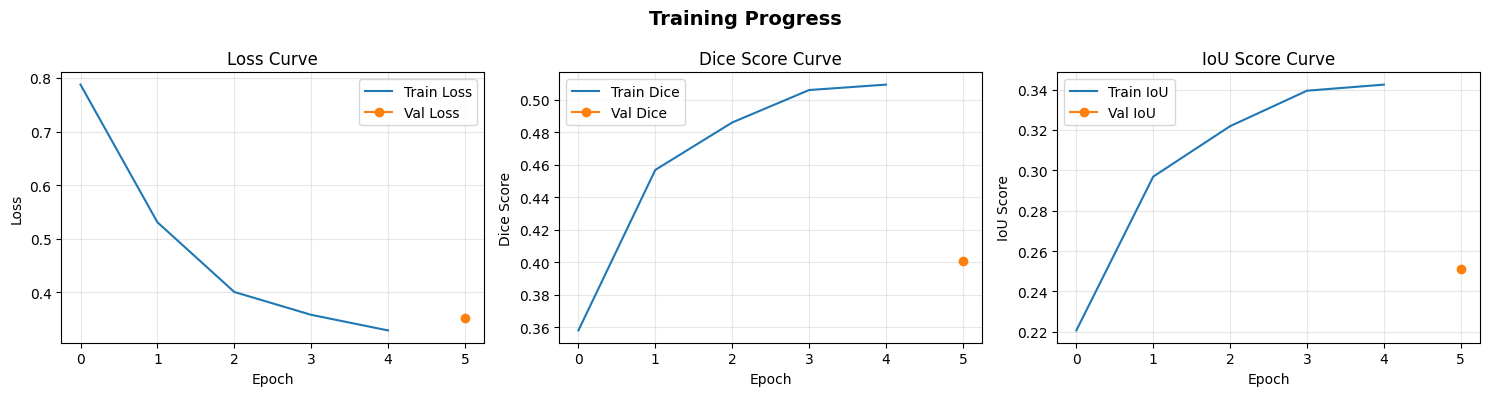

In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Training Progress', fontsize=14, fontweight='bold')

axes[0].plot(epoch_losses, label='Train Loss')
if val_losses:
    val_epochs = list(range(validate_every, max_epochs + 1, validate_every))
    if max_epochs not in val_epochs:
        val_epochs.append(max_epochs)
    axes[0].plot(val_epochs[:len(val_losses)], val_losses, 'o-', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epoch_dice_scores, label='Train Dice')
if val_dice_scores:
    axes[1].plot(val_epochs[:len(val_dice_scores)], val_dice_scores, 'o-', label='Val Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Dice Score Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epoch_iou_scores, label='Train IoU')
if val_iou_scores:
    axes[2].plot(val_epochs[:len(val_iou_scores)], val_iou_scores, 'o-', label='Val IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('IoU Score Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to: {os.path.join(log_dir, 'training_curves.png')}")
plt.show()

## Validation Case


UNET TRAINED MODEL - VALIDATION SET EVALUATION (Multi-class)

Loading BEST model checkpoint for validation...
✓ Loading checkpoint: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\net_checkpoint_0.pt
✓ Best model loaded successfully!

Validation set size: 100 samples
Running inference on VALIDATION SET with BEST MODEL...

VAL 1: Single Validation Image
----------------------------------------------------------------------
✓ Inference Time: 0.2597s
✓ Multi-class DICE: 0.4259
✓ Multi-class IoU: 0.2706

VAL 2: Full Validation Set Evaluation
----------------------------------------------------------------------


Validation Set Inference:   0%|          | 0/100 [00:00<?]


✓ Total Time: 18.10s
✓ Avg Time per Sample: 0.0571s
✓ Throughput: 5.52 samples/s
✓ Avg Multi-class DICE: 0.4013 ± 0.0499
✓ Avg Multi-class IoU: 0.2521 ± 0.0345


VALIDATION SET VISUALIZATION - Sample Results (Multi-class)
✓ Validation visualization saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\unet_validation_results_mc.png


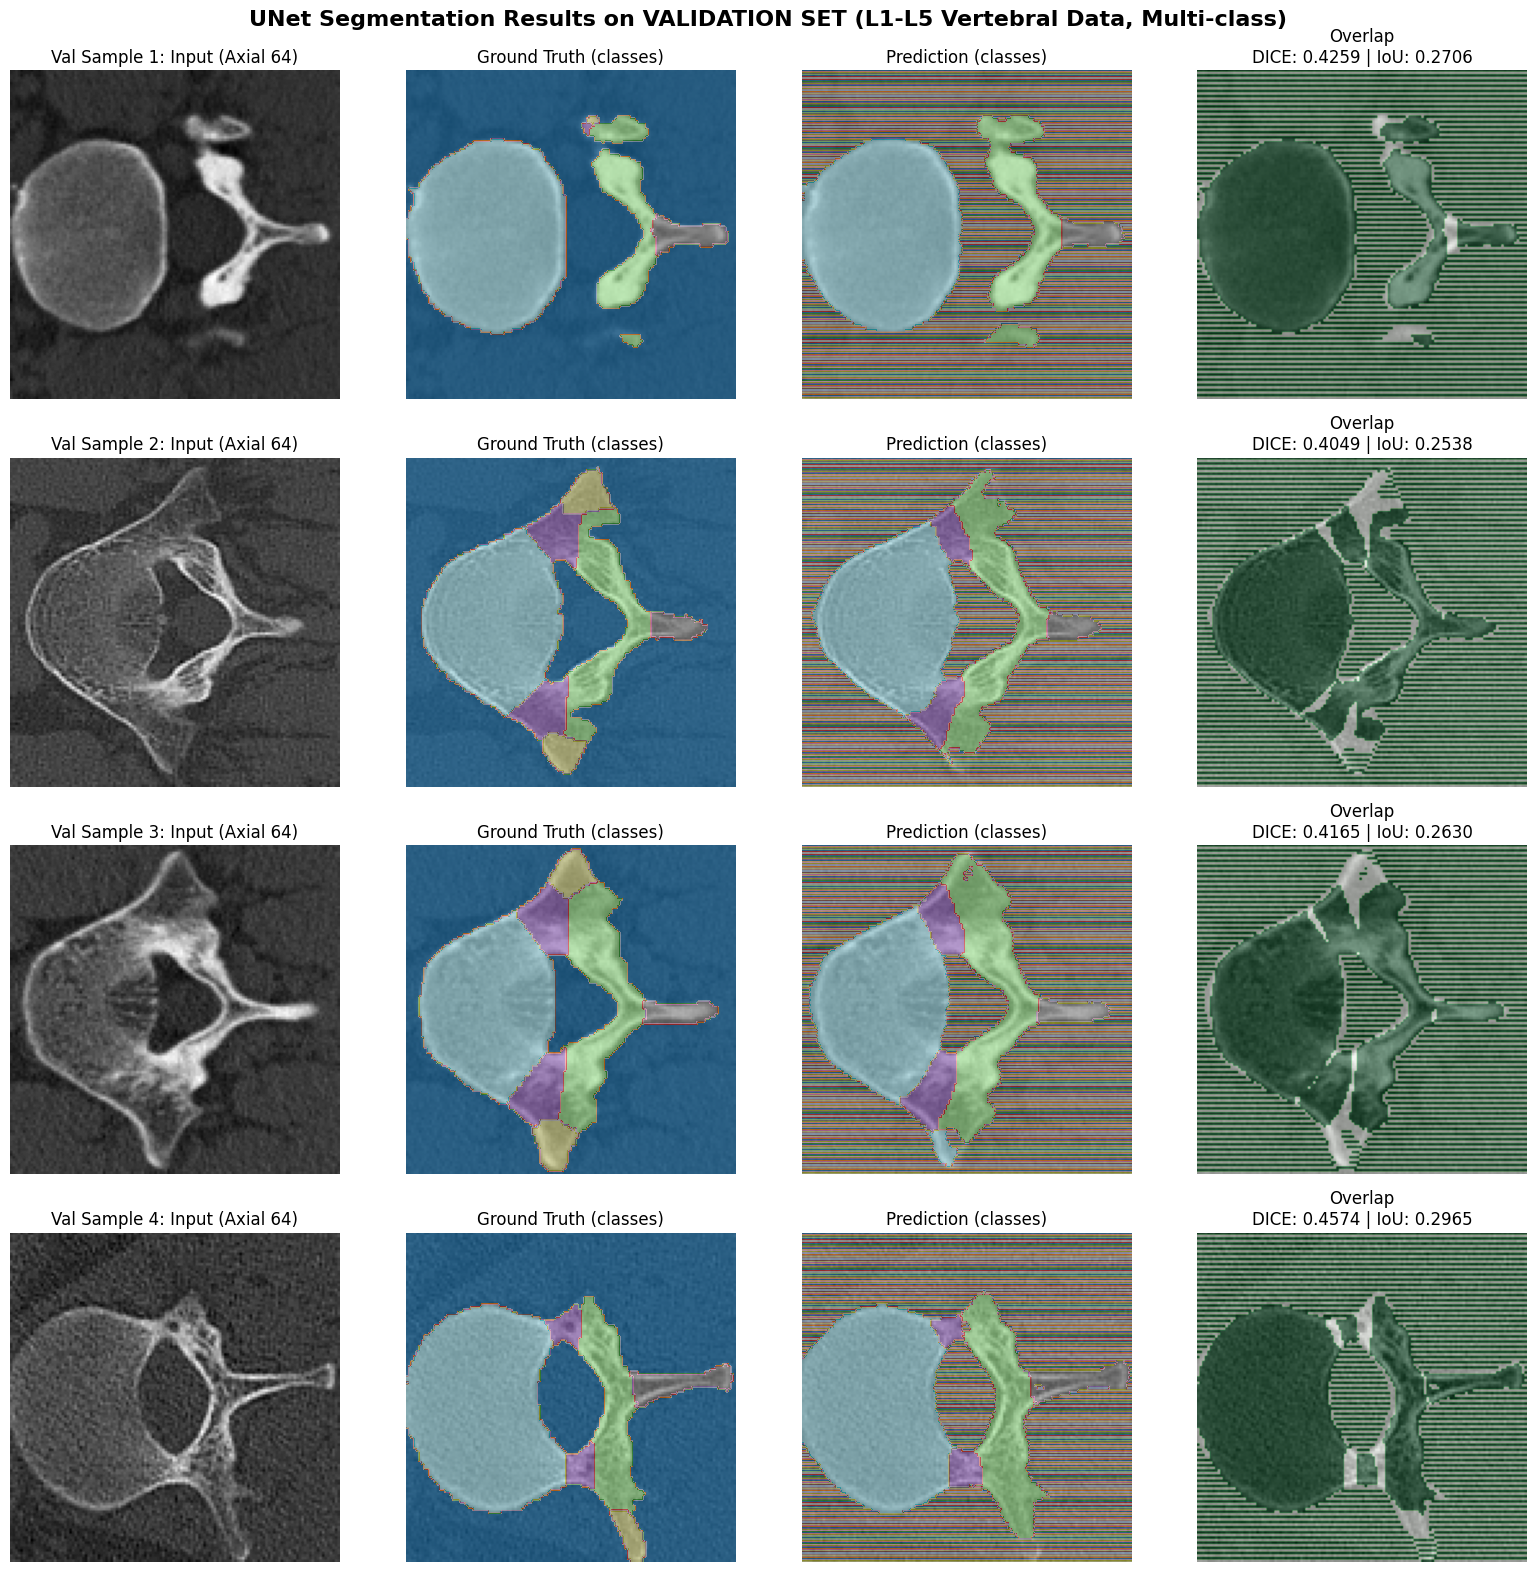


VALIDATION SET PERFORMANCE SUMMARY

                           Metric  Samples Avg Time/Sample (s) Throughput (samples/s)   Avg DICE (MC)    Avg IoU (MC)
                    Single Sample        1              0.2597                   3.85          0.4259          0.2706
Full Validation Set (100 samples)      100              0.0571                   5.52 0.4013 ± 0.0499 0.2521 ± 0.0345

✓ Per-sample results saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\validation_set_results.csv


In [12]:
# Helper metric functions (multi-class)
def calculate_dice_score_mc(logits: torch.Tensor, target: torch.Tensor, num_classes: int) -> float:
    probs = torch.softmax(logits, dim=1)
    pred_onehot = F.one_hot(torch.argmax(probs, dim=1), num_classes=num_classes).permute(0,4,1,2,3)
    tgt_onehot = F.one_hot(target.long().squeeze(1), num_classes=num_classes).permute(0,4,1,2,3)
    pred_onehot = pred_onehot[:, 1:]
    tgt_onehot = tgt_onehot[:, 1:]
    inter = (pred_onehot * tgt_onehot).sum().item()
    denom = pred_onehot.sum().item() + tgt_onehot.sum().item() + 1e-6
    return (2.0 * inter) / denom

def calculate_iou_score_mc(logits: torch.Tensor, target: torch.Tensor, num_classes: int) -> float:
    probs = torch.softmax(logits, dim=1)
    pred_onehot = F.one_hot(torch.argmax(probs, dim=1), num_classes=num_classes).permute(0,4,1,2,3)
    tgt_onehot = F.one_hot(target.long().squeeze(1), num_classes=num_classes).permute(0,4,1,2,3)
    pred_onehot = pred_onehot[:, 1:]
    tgt_onehot = tgt_onehot[:, 1:]
    inter = (pred_onehot * tgt_onehot).sum().item()
    union = pred_onehot.sum().item() + tgt_onehot.sum().item() - inter + 1e-6
    return inter / union

def clear_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*100)
print("UNET TRAINED MODEL - VALIDATION SET EVALUATION (Multi-class)")
print("="*100)

# ============================================================================
# LOAD BEST MODEL CHECKPOINT
# ============================================================================
print("\nLoading BEST model checkpoint for validation...")

try:
    base_dir = directory
except NameError:
    base_dir = "D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case"

log_dir = os.path.join(base_dir, "logs")

# Discover available checkpoints
ckpt_patterns = [
    os.path.join(log_dir, "net_*.pt"),
    os.path.join(log_dir, "net_checkpoint_*.pt"),
    os.path.join(log_dir, "*.pt"),
]

candidate_files = []
for pat in ckpt_patterns:
    candidate_files.extend(glob.glob(pat))

if not candidate_files:
    raise FileNotFoundError(f"No checkpoint .pt files found in: {log_dir}")

# Pick the most recently modified checkpoint (best model saved last)
model_path = max(candidate_files, key=os.path.getmtime)
print(f"✓ Loading checkpoint: {model_path}")

# Load checkpoint
map_loc = "cuda:0" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(model_path, map_location=map_loc)

# Extract state_dict from checkpoint
if isinstance(checkpoint, dict) and "net" in checkpoint:
    state_dict = checkpoint["net"] if isinstance(checkpoint["net"], dict) else checkpoint["net"].state_dict()
elif isinstance(checkpoint, dict) and "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
elif isinstance(checkpoint, dict):
    state_dict = checkpoint
else:
    state_dict = checkpoint.state_dict()

# Load into real_net
real_net.load_state_dict(state_dict, strict=False)
print("✓ Best model loaded successfully!")

print(f"\nValidation set size: {len(val_ds)} samples")
print("Running inference on VALIDATION SET with BEST MODEL...\n")

# Ensure val_ds exists
assert 'val_ds' in globals() and 'val_loader' in globals(), "Run data loading cells first to build val_ds and val_loader."
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = real_net.to(device)
model.eval()

# Build a simple list of samples (image, label) from validation dataset
def _get_val_sample(idx):
    img, lbl = val_ds[idx]
    if img.ndim == 4:
        img = img.unsqueeze(0)
    if lbl.ndim == 4:
        lbl = lbl.unsqueeze(0)
    return img, lbl

# VAL 1: Single validation image
print("VAL 1: Single Validation Image")
print("-" * 70)
val1_results = {"inference_time": 0.0, "dice": 0.0, "iou": 0.0}

if len(val_ds) > 0:
    val_image, val_label = _get_val_sample(0)
    with torch.no_grad():
        start_time = time.time()
        output = model(val_image.to(device))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        val1_results["inference_time"] = time.time() - start_time
        val1_results["dice"] = calculate_dice_score_mc(output, val_label.to(device), num_classes)
        val1_results["iou"] = calculate_iou_score_mc(output, val_label.to(device), num_classes)
    print(f"✓ Inference Time: {val1_results['inference_time']:.4f}s")
    print(f"✓ Multi-class DICE: {val1_results['dice']:.4f}")
    print(f"✓ Multi-class IoU: {val1_results['iou']:.4f}\n")
    clear_cuda_memory()
else:
    print("Validation dataset is empty.")

# VAL 2: Full validation set evaluation
print("VAL 2: Full Validation Set Evaluation")
print("-" * 70)
val2_results = {
    "total_time": 0.0,
    "avg_time": 0.0,
    "avg_dice": 0.0,
    "avg_iou": 0.0,
    "num_samples": len(val_ds)
}

val_dice_scores_eval = []
val_iou_scores_eval = []
val_times = []

with torch.no_grad():
    batch_start = time.time()
    batch_pbar = tqdm(range(len(val_ds)), desc="Validation Set Inference", unit="sample",
                      bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
    for i in batch_pbar:
        val_image, val_label = _get_val_sample(i)
        t_start = time.time()
        output = model(val_image.to(device))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t_elapsed = time.time() - t_start
        val_times.append(t_elapsed)
        dice = calculate_dice_score_mc(output, val_label.to(device), num_classes)
        iou = calculate_iou_score_mc(output, val_label.to(device), num_classes)
        val_dice_scores_eval.append(dice)
        val_iou_scores_eval.append(iou)
        batch_pbar.set_postfix({'time': f'{t_elapsed:.4f}s', 'dice': f'{dice:.4f}', 'iou': f'{iou:.4f}'})
    val2_results["total_time"] = time.time() - batch_start

if len(val_times) > 0:
    val2_results["avg_time"] = float(np.mean(val_times))
    val2_results["avg_dice"] = float(np.mean(val_dice_scores_eval))
    val2_results["avg_iou"] = float(np.mean(val_iou_scores_eval))
    val2_results["std_dice"] = float(np.std(val_dice_scores_eval))
    val2_results["std_iou"] = float(np.std(val_iou_scores_eval))

print(f"\n✓ Total Time: {val2_results['total_time']:.2f}s")
print(f"✓ Avg Time per Sample: {val2_results['avg_time']:.4f}s")
val_throughput = (val2_results['num_samples']/val2_results['total_time']) if val2_results['total_time']>0 else float('nan')
print(f"✓ Throughput: {val_throughput:.2f} samples/s")
print(f"✓ Avg Multi-class DICE: {val2_results['avg_dice']:.4f} ± {val2_results.get('std_dice', 0):.4f}")
print(f"✓ Avg Multi-class IoU: {val2_results['avg_iou']:.4f} ± {val2_results.get('std_iou', 0):.4f}\n")

clear_cuda_memory()

# Visualization of validation samples
print("\n" + "="*100)
print("VALIDATION SET VISUALIZATION - Sample Results (Multi-class)")
print("="*100)

num_vis_samples = min(4, len(val_ds))
if num_vis_samples > 0:
    fig, axes = plt.subplots(num_vis_samples, 4, figsize=(16, 4*num_vis_samples))
    fig.suptitle('UNet Segmentation Results on VALIDATION SET (L1-L5 Vertebral Data, Multi-class)', fontsize=16, fontweight='bold')
    model.eval()
    with torch.no_grad():
        for i in range(num_vis_samples):
            val_image, val_label = _get_val_sample(i)
            output = model(val_image.to(device))
            probs = torch.softmax(output, dim=1)
            pred_classes = torch.argmax(probs, dim=1).cpu()

            img_np = val_image.squeeze().cpu().numpy()
            label_np = val_label.squeeze().cpu().numpy()
            pred_np = pred_classes.squeeze().numpy()

            mid_slice = img_np.shape[-1] // 2
            dice = calculate_dice_score_mc(output, val_label.to(device), num_classes)
            iou = calculate_iou_score_mc(output, val_label.to(device), num_classes)

            axes[i, 0].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 0].set_title(f'Val Sample {i+1}: Input (Axial {mid_slice})')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 1].imshow(label_np[:, :, mid_slice], cmap='tab20', alpha=0.6)
            axes[i, 1].set_title('Ground Truth (classes)')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 2].imshow(pred_np[:, :, mid_slice], cmap='tab20', alpha=0.6)
            axes[i, 2].set_title('Prediction (classes)')
            axes[i, 2].axis('off')

            comparison = (label_np[:, :, mid_slice] == pred_np[:, :, mid_slice]).astype(np.float32)
            axes[i, 3].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 3].imshow(comparison, cmap='Greens', alpha=0.5)
            axes[i, 3].set_title(f'Overlap\nDICE: {dice:.4f} | IoU: {iou:.4f}')
            axes[i, 3].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'unet_validation_results_mc.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Validation visualization saved to: {os.path.join(log_dir, 'unet_validation_results_mc.png')}")
    plt.show()
else:
    print("Validation dataset is empty; skip visualization.")

# Summary
print("\n" + "="*100)
print("VALIDATION SET PERFORMANCE SUMMARY")
print("="*100)

val_summary_data = {
    "Metric": ["Single Sample", f"Full Validation Set ({val2_results['num_samples']} samples)"],
    "Samples": [1, val2_results["num_samples"]],
    "Avg Time/Sample (s)": [f"{val1_results['inference_time']:.4f}", f"{val2_results['avg_time']:.4f}"],
    "Throughput (samples/s)": [
        f"{(1/val1_results['inference_time']) if val1_results['inference_time']>0 else float('nan'):.2f}",
        f"{val_throughput:.2f}"
    ],
    "Avg DICE (MC)": [f"{val1_results['dice']:.4f}", f"{val2_results['avg_dice']:.4f} ± {val2_results.get('std_dice', 0):.4f}"],
    "Avg IoU (MC)": [f"{val1_results['iou']:.4f}", f"{val2_results['avg_iou']:.4f} ± {val2_results.get('std_iou', 0):.4f}"]
}

df_val_summary = pd.DataFrame(val_summary_data)
print("\n" + df_val_summary.to_string(index=False))

# Per-sample results
val_per_sample_df = pd.DataFrame({
    'Sample': list(range(1, len(val_ds) + 1)),
    'DICE': val_dice_scores_eval,
    'IoU': val_iou_scores_eval,
    'Inference Time (s)': val_times
})

val_results_csv = os.path.join(log_dir, "validation_set_results.csv")
val_per_sample_df.to_csv(val_results_csv, index=False)
print(f"\n{'='*100}")
print(f"✓ Per-sample results saved to: {val_results_csv}")

clear_cuda_memory()

## Test Case


UNET TRAINED MODEL - TEST SET EVALUATION (Multi-class)

Loading BEST model checkpoint for testing...
✓ Loading checkpoint: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\net_checkpoint_0.pt
✓ Best model loaded successfully!

Test set size: 133 samples
Running inference on TEST SET with BEST MODEL...

TEST 1: Single Test Image
----------------------------------------------------------------------
✓ Inference Time: 0.1550s
✓ Multi-class DICE: 0.8437
✓ Multi-class IoU: 0.7296

TEST 2: Full Test Set Evaluation
----------------------------------------------------------------------
✓ Inference Time: 0.1550s
✓ Multi-class DICE: 0.8437
✓ Multi-class IoU: 0.7296

TEST 2: Full Test Set Evaluation
----------------------------------------------------------------------


Test Set Inference:   0%|          | 0/133 [00:00<?]


✓ Total Time: 26.21s
✓ Avg Time per Sample: 0.0563s
✓ Throughput: 5.07 samples/s
✓ Avg Multi-class DICE: 0.8729 ± 0.0382
✓ Avg Multi-class IoU: 0.7763 ± 0.0555


TEST SET VISUALIZATION - Sample Results (Multi-class)
✓ Test visualization saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\unet_test_results_mc.png
✓ Test visualization saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\unet_test_results_mc.png


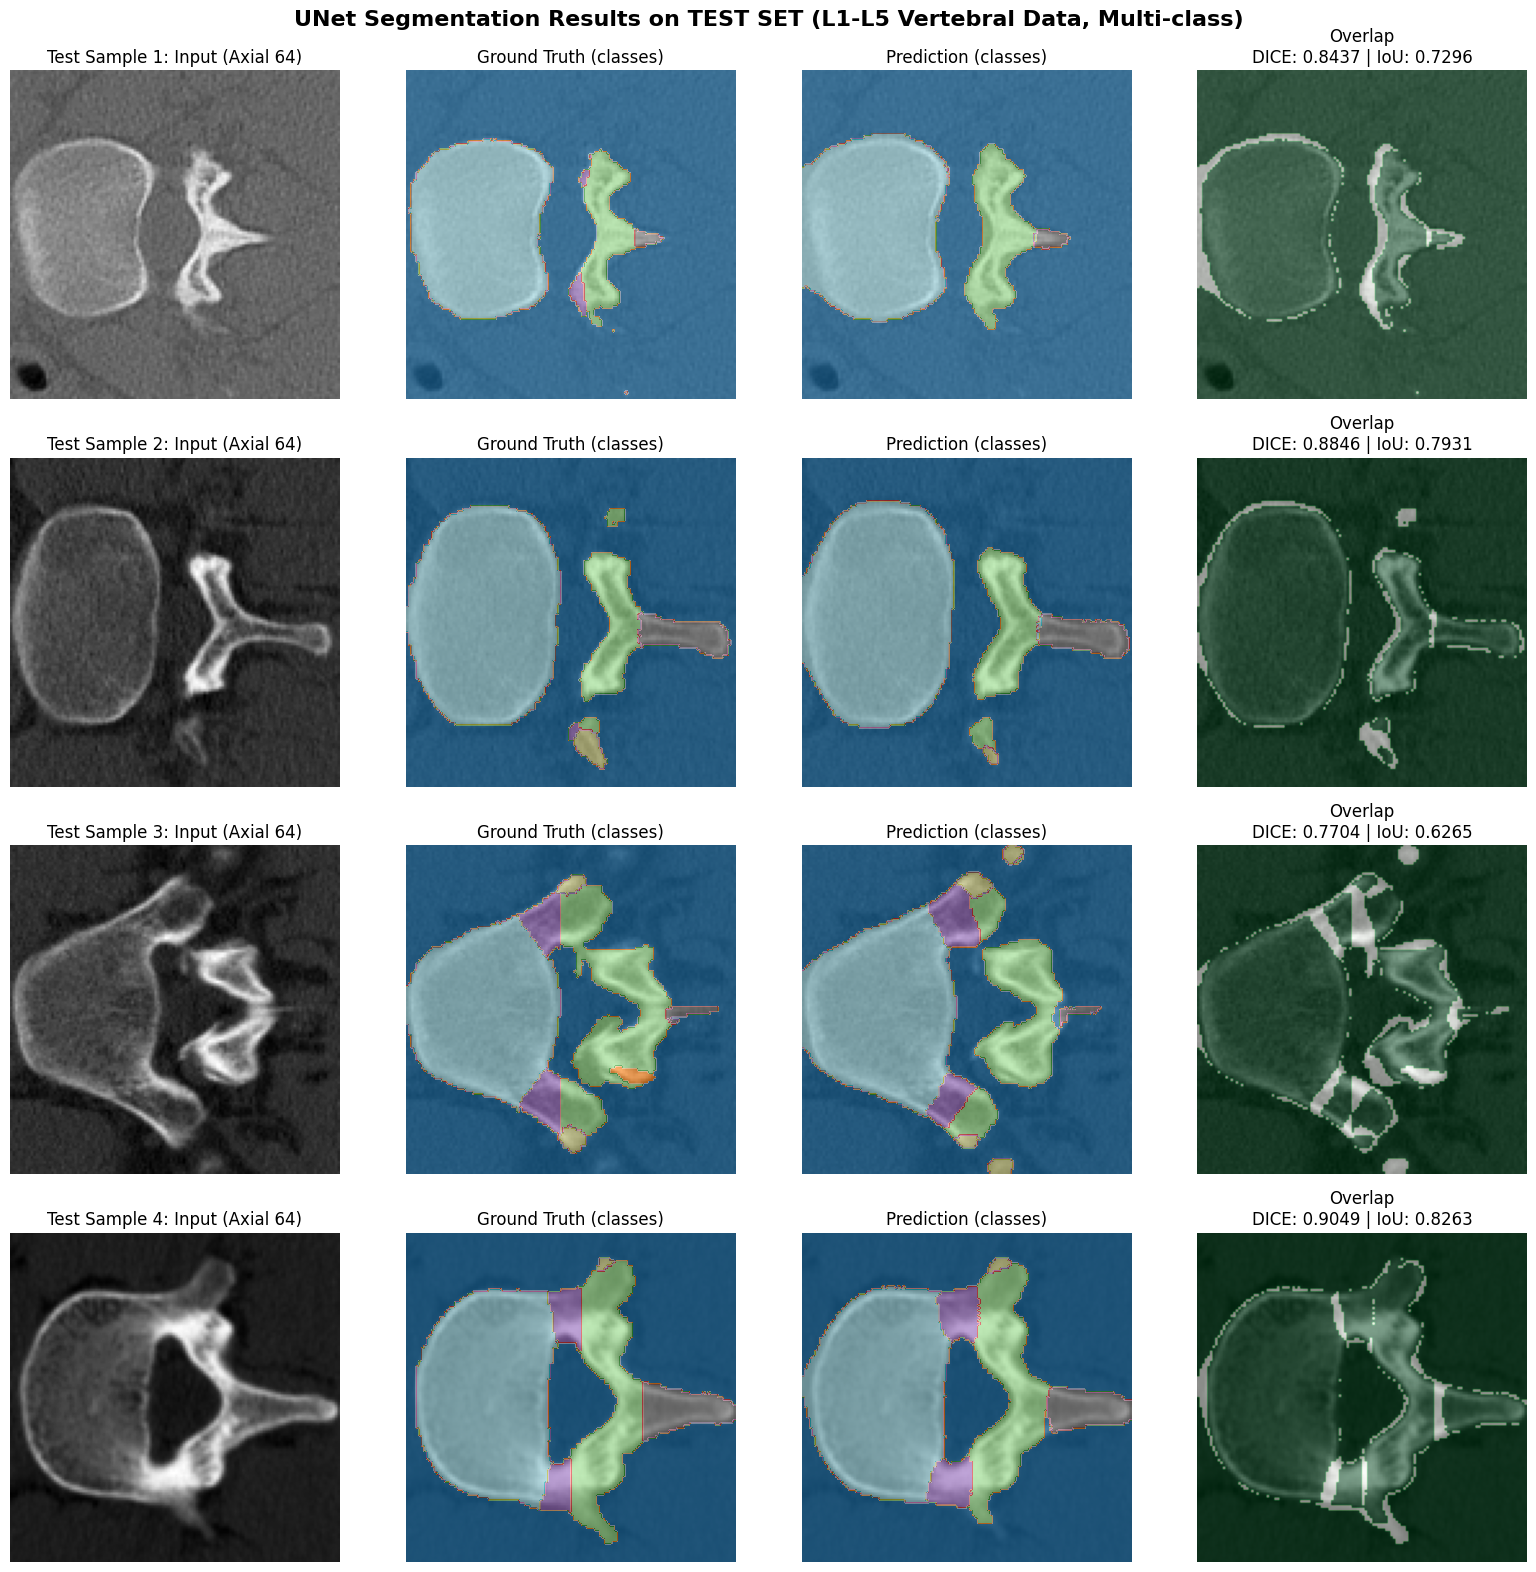


TEST SET PERFORMANCE SUMMARY

                     Metric  Samples Avg Time/Sample (s) Throughput (samples/s)   Avg DICE (MC)    Avg IoU (MC)
              Single Sample        1              0.1550                   6.45          0.8437          0.7296
Full Test Set (133 samples)      133              0.0563                   5.07 0.8729 ± 0.0382 0.7763 ± 0.0555

✓ Per-sample results saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\test_set_results.csv
✓ Test visualization saved to: D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case\logs\unet_test_results_mc.png

DATA SPLIT SUMMARY
Training set:   430 samples
Validation set: 100 samples
Test set:       133 samples
Total:          663 samples


In [21]:
# Helper metric functions (multi-class)
def calculate_dice_score_mc(logits: torch.Tensor, target: torch.Tensor, num_classes: int) -> float:
    probs = torch.softmax(logits, dim=1)
    pred_onehot = F.one_hot(torch.argmax(probs, dim=1), num_classes=num_classes).permute(0,4,1,2,3)
    tgt_onehot = F.one_hot(target.long().squeeze(1), num_classes=num_classes).permute(0,4,1,2,3)
    pred_onehot = pred_onehot[:, 1:]
    tgt_onehot = tgt_onehot[:, 1:]
    inter = (pred_onehot * tgt_onehot).sum().item()
    denom = pred_onehot.sum().item() + tgt_onehot.sum().item() + 1e-6
    return (2.0 * inter) / denom

def calculate_iou_score_mc(logits: torch.Tensor, target: torch.Tensor, num_classes: int) -> float:
    probs = torch.softmax(logits, dim=1)
    pred_onehot = F.one_hot(torch.argmax(probs, dim=1), num_classes=num_classes).permute(0,4,1,2,3)
    tgt_onehot = F.one_hot(target.long().squeeze(1), num_classes=num_classes).permute(0,4,1,2,3)
    pred_onehot = pred_onehot[:, 1:]
    tgt_onehot = tgt_onehot[:, 1:]
    inter = (pred_onehot * tgt_onehot).sum().item()
    union = pred_onehot.sum().item() + tgt_onehot.sum().item() - inter + 1e-6
    return inter / union

def clear_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*100)
print("UNET TRAINED MODEL - TEST SET EVALUATION (Multi-class)")
print("="*100)

# ============================================================================
# LOAD BEST MODEL CHECKPOINT
# ============================================================================
print("\nLoading BEST model checkpoint for testing...")

try:
    base_dir = directory
except NameError:
    base_dir = "D:/Senior Project/tutorials-main/3d_segmentation/L1-L5FineSegMix-663case"

log_dir = os.path.join(base_dir, "logs")

# Discover available checkpoints
ckpt_patterns = [
    os.path.join(log_dir, "net_*.pt"),
    os.path.join(log_dir, "net_checkpoint_*.pt"),
    os.path.join(log_dir, "*.pt"),
]

candidate_files = []
for pat in ckpt_patterns:
    candidate_files.extend(glob.glob(pat))

if not candidate_files:
    raise FileNotFoundError(f"No checkpoint .pt files found in: {log_dir}")

# Pick the most recently modified checkpoint (best model saved last)
model_path = max(candidate_files, key=os.path.getmtime)
print(f"✓ Loading checkpoint: {model_path}")

# Load checkpoint
map_loc = "cuda:0" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(model_path, map_location=map_loc)

# Extract state_dict from checkpoint
if isinstance(checkpoint, dict) and "net" in checkpoint:
    state_dict = checkpoint["net"] if isinstance(checkpoint["net"], dict) else checkpoint["net"].state_dict()
elif isinstance(checkpoint, dict) and "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
elif isinstance(checkpoint, dict):
    state_dict = checkpoint
else:
    state_dict = checkpoint.state_dict()

# Load into real_net
real_net.load_state_dict(state_dict, strict=False)
print("✓ Best model loaded successfully!")

print(f"\nTest set size: {len(test_ds)} samples")
print("Running inference on TEST SET with BEST MODEL...\n")

# Use test_ds and test_loader for evaluation
assert 'test_ds' in globals() and 'test_loader' in globals(), "Run data loading cells first to build test_ds and test_loader."
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = real_net.to(device)
model.eval()

# Build a simple list of samples (image, label) from test dataset
def _get_test_sample(idx):
    img, lbl = test_ds[idx]
    if img.ndim == 4:
        img = img.unsqueeze(0)
    if lbl.ndim == 4:
        lbl = lbl.unsqueeze(0)
    return img, lbl

# TEST 1: Single test image
print("TEST 1: Single Test Image")
print("-" * 70)
test1_results = {"inference_time": 0.0, "dice": 0.0, "iou": 0.0}

if len(test_ds) > 0:
    test_image, test_label = _get_test_sample(0)
    with torch.no_grad():
        start_time = time.time()
        output = model(test_image.to(device))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        test1_results["inference_time"] = time.time() - start_time
        test1_results["dice"] = calculate_dice_score_mc(output, test_label.to(device), num_classes)
        test1_results["iou"] = calculate_iou_score_mc(output, test_label.to(device), num_classes)
    print(f"✓ Inference Time: {test1_results['inference_time']:.4f}s")
    print(f"✓ Multi-class DICE: {test1_results['dice']:.4f}")
    print(f"✓ Multi-class IoU: {test1_results['iou']:.4f}\n")
    clear_cuda_memory()
else:
    print("Test dataset is empty.")

# TEST 2: Full test set evaluation
print("TEST 2: Full Test Set Evaluation")
print("-" * 70)
test2_results = {
    "total_time": 0.0,
    "avg_time": 0.0,
    "avg_dice": 0.0,
    "avg_iou": 0.0,
    "num_samples": len(test_ds)
}

dice_scores = []
iou_scores = []
times = []

with torch.no_grad():
    batch_start = time.time()
    batch_pbar = tqdm(range(len(test_ds)), desc="Test Set Inference", unit="sample",
                      bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')
    for i in batch_pbar:
        test_image, test_label = _get_test_sample(i)
        t_start = time.time()
        output = model(test_image.to(device))
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t_elapsed = time.time() - t_start
        times.append(t_elapsed)
        dice = calculate_dice_score_mc(output, test_label.to(device), num_classes)
        iou = calculate_iou_score_mc(output, test_label.to(device), num_classes)
        dice_scores.append(dice)
        iou_scores.append(iou)
        batch_pbar.set_postfix({'time': f'{t_elapsed:.4f}s', 'dice': f'{dice:.4f}', 'iou': f'{iou:.4f}'})
    test2_results["total_time"] = time.time() - batch_start

if len(times) > 0:
    test2_results["avg_time"] = float(np.mean(times))
    test2_results["avg_dice"] = float(np.mean(dice_scores))
    test2_results["avg_iou"] = float(np.mean(iou_scores))
    test2_results["std_dice"] = float(np.std(dice_scores))
    test2_results["std_iou"] = float(np.std(iou_scores))

print(f"\n✓ Total Time: {test2_results['total_time']:.2f}s")
print(f"✓ Avg Time per Sample: {test2_results['avg_time']:.4f}s")
throughput = (test2_results['num_samples']/test2_results['total_time']) if test2_results['total_time']>0 else float('nan')
print(f"✓ Throughput: {throughput:.2f} samples/s")
print(f"✓ Avg Multi-class DICE: {test2_results['avg_dice']:.4f} ± {test2_results.get('std_dice', 0):.4f}")
print(f"✓ Avg Multi-class IoU: {test2_results['avg_iou']:.4f} ± {test2_results.get('std_iou', 0):.4f}\n")

clear_cuda_memory()

# Visualization of test samples
print("\n" + "="*100)
print("TEST SET VISUALIZATION - Sample Results (Multi-class)")
print("="*100)

num_vis_samples = min(4, len(test_ds))
if num_vis_samples > 0:
    fig, axes = plt.subplots(num_vis_samples, 4, figsize=(16, 4*num_vis_samples))
    fig.suptitle('UNet Segmentation Results on TEST SET (L1-L5 Vertebral Data, Multi-class)', fontsize=16, fontweight='bold')
    model.eval()
    with torch.no_grad():
        for i in range(num_vis_samples):
            test_image, test_label = _get_test_sample(i)
            output = model(test_image.to(device))
            probs = torch.softmax(output, dim=1)
            pred_classes = torch.argmax(probs, dim=1).cpu()

            img_np = test_image.squeeze().cpu().numpy()
            label_np = test_label.squeeze().cpu().numpy()
            pred_np = pred_classes.squeeze().numpy()

            mid_slice = img_np.shape[-1] // 2
            dice = calculate_dice_score_mc(output, test_label.to(device), num_classes)
            iou = calculate_iou_score_mc(output, test_label.to(device), num_classes)

            axes[i, 0].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 0].set_title(f'Test Sample {i+1}: Input (Axial {mid_slice})')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 1].imshow(label_np[:, :, mid_slice], cmap='tab20', alpha=0.6)
            axes[i, 1].set_title('Ground Truth (classes)')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 2].imshow(pred_np[:, :, mid_slice], cmap='tab20', alpha=0.6)
            axes[i, 2].set_title('Prediction (classes)')
            axes[i, 2].axis('off')

            comparison = (label_np[:, :, mid_slice] == pred_np[:, :, mid_slice]).astype(np.float32)
            axes[i, 3].imshow(img_np[:, :, mid_slice], cmap='gray')
            axes[i, 3].imshow(comparison, cmap='Greens', alpha=0.5)
            axes[i, 3].set_title(f'Overlap\nDICE: {dice:.4f} | IoU: {iou:.4f}')
            axes[i, 3].axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(log_dir, 'unet_test_results_mc.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Test visualization saved to: {os.path.join(log_dir, 'unet_test_results_mc.png')}")
    plt.show()
else:
    print("Test dataset is empty; skip visualization.")

# Summary
print("\n" + "="*100)
print("TEST SET PERFORMANCE SUMMARY")
print("="*100)

summary_data = {
    "Metric": ["Single Sample", f"Full Test Set ({test2_results['num_samples']} samples)"],
    "Samples": [1, test2_results["num_samples"]],
    "Avg Time/Sample (s)": [f"{test1_results['inference_time']:.4f}", f"{test2_results['avg_time']:.4f}"],
    "Throughput (samples/s)": [
        f"{(1/test1_results['inference_time']) if test1_results['inference_time']>0 else float('nan'):.2f}",
        f"{throughput:.2f}"
    ],
    "Avg DICE (MC)": [f"{test1_results['dice']:.4f}", f"{test2_results['avg_dice']:.4f} ± {test2_results.get('std_dice', 0):.4f}"],
    "Avg IoU (MC)": [f"{test1_results['iou']:.4f}", f"{test2_results['avg_iou']:.4f} ± {test2_results.get('std_iou', 0):.4f}"]
}

df_summary = pd.DataFrame(summary_data)
print("\n" + df_summary.to_string(index=False))

# Per-sample results
per_sample_df = pd.DataFrame({
    'Sample': list(range(1, len(test_ds) + 1)),
    'DICE': dice_scores,
    'IoU': iou_scores,
    'Inference Time (s)': times
})

results_csv = os.path.join(log_dir, "test_set_results.csv")
per_sample_df.to_csv(results_csv, index=False)
print(f"\n{'='*100}")
print(f"✓ Per-sample results saved to: {results_csv}")
print(f"✓ Test visualization saved to: {os.path.join(log_dir, 'unet_test_results_mc.png')}")

# Data split summary
print(f"\n{'='*100}")
print("DATA SPLIT SUMMARY")
print("="*100)
print(f"Training set:   {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set:       {len(test_ds)} samples")
print(f"Total:          {len(train_ds) + len(val_ds) + len(test_ds)} samples")

del model
clear_cuda_memory()

In [ ]:
try:
    _ = log_dir
except NameError:
    log_dir = os.path.join(directory, "logs")

os.makedirs(log_dir, exist_ok=True)

# Get one batch
first_batch = next(iter(real_loader))
img, lbl = first_batch  # shapes: (B, C, H, W, D)

# Run a quick prediction
real_net.eval()
with torch.no_grad():
    pred = torch.softmax(real_net(img.to(device)), dim=1).cpu()  # (B, num_classes, H, W, D)
    pred_argmax = torch.argmax(pred, dim=1, keepdim=True)        # (B,1,H,W,D)

# Take a central depth slice to log as 2D images
depth_idx = img.shape[-1] // 2
img2d = img[..., depth_idx]
lbl2d = lbl[..., depth_idx]
pred2d = pred_argmax[..., depth_idx].float()

# Normalize to [0,1] per-tensor for visualization
def _norm01(x: torch.Tensor):
    x = x.float()
    minv = x.amin(dim=[-2, -1], keepdim=True)
    maxv = x.amax(dim=[-2, -1], keepdim=True)
    return (x - minv) / (maxv - minv + 1e-6)

img2d = _norm01(img2d)
# Labels and preds are categorical; scale to [0,1] for visualization only
lbl2d_vis = (lbl2d.float() / max(num_classes - 1, 1))
pred2d_vis = (pred2d.float() / max(num_classes - 1, 1))

# Write to TensorBoard
writer = SummaryWriter(log_dir=log_dir)
step = int(getattr(trainer.state, "epoch", 0)) if "trainer" in globals() else 0
writer.add_images("inputs/central_slice", img2d, global_step=step)
writer.add_images("labels/central_slice", lbl2d_vis, global_step=step)
writer.add_images("preds/central_slice", pred2d_vis, global_step=step)
writer.flush()
writer.close()


In [ ]:
os.environ["TENSORBOARD_BINARY"] = "C:/Users/Sawitt/AppData/Local/Programs/Python/Python312/Scripts/tensorboard.exe"

In [ ]:
print("TensorBoard logdir:", os.path.abspath(log_dir))

In [ ]:
%load_ext tensorboard
tb_logdir = os.path.abspath(log_dir)
print("Starting TensorBoard at:", tb_logdir)
%tensorboard --logdir "{tb_logdir}" --port 6005